In [1]:
# Dependencies
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import calendar
import statsmodels.formula.api as sm
from sklearn.linear_model import LinearRegression
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Reading the cleaned 25% sample data from csv to use forward
data_df = pd.read_csv('Resources/sample_data_cleaned.csv')
# ------ TEMPORARY ----------
data_df = data_df.sample(frac=.25)

In [3]:
#Understanding the data structure before we moved on
data_df.tail()

,Unnamed: 0,Unnamed: 0.1,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
7685259,7712468,8813001,2014-06-27 17:43:32.0000001,8.5,2014-06-27 17:43:32 UTC,-73.953313,40.767437,-73.973020,40.782557,1
3663536,3676420,19097668,2010-04-09 14:51:17.0000004,9.3,2010-04-09 14:51:17 UTC,-74.006403,40.732920,-73.985912,40.762513,1
4036594,4050807,19969306,2014-12-08 07:34:58.0000005,4.0,2014-12-08 07:34:58 UTC,-74.004178,40.721869,-73.999299,40.722699,1
8993484,9025399,47388891,2014-12-31 06:47:48.0000001,5.0,2014-12-31 06:47:48 UTC,-73.992947,40.750114,-73.991988,40.749933,2
8588690,8619180,8811021,2010-10-27 06:21:00.00000019,8.1,2010-10-27 06:21:00 UTC,-73.948735,40.770798,-73.977458,40.752068,1


In [4]:
#Our weather data only includes data from 2013 - 2016, so in our sampled data,
#we also filtered out data from the other years
data_df['new_time'] = (data_df['pickup_datetime']).apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S %Z"))    
data_df = data_df.drop(['Unnamed: 0','key','pickup_datetime'], axis=1)
time_range = (data_df['new_time'] >= "2013-01-01") & (data_df['new_time'] <= "2016-12-31")
ranged_data = data_df.loc[time_range]

In [49]:
#calculate the distance between pick-up and drop-off spot in kilometer


def distance_from_coord(lat1, lon1, lat2, lon2):
    radius = 6371  # km
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    return d



def distance(row):

    lat1, lon1 = row['pickup_latitude'], row['pickup_longitude']
    lat2, lon2 = row['dropoff_latitude'], row['dropoff_longitude']
    return distance_from_coord(lat1, lon1, lat2, lon2)

#apply the distance calculation function into the dataframe
ranged_data['distance'] = data_df.apply(distance, axis=1)

#Clean out travel distance that is more than 100 km (data analysis is limited in NYC)
ranged_data = ranged_data[ranged_data['distance'] < 100]

In [69]:
# Add a boolean column to check whether the tide was airport ride
jfk_lat = -73.7781 
jfk_lon = 40.6413
ewr_lat = -74.1745
ewr_lon = 40.6895
lgr_lat = -73.8740
lgr_lon = 40.7769

def is_airport(pick_lat, pick_lon, drop_lat, drop_lon):
    distances = []
    distances.append(distance_from_coord(pick_lat, pick_lon, jfk_lat, jfk_lon))
    distances.append(distance_from_coord(pick_lat, pick_lon, ewr_lat, ewr_lon))
    distances.append(distance_from_coord(pick_lat, pick_lon, lgr_lat, lgr_lon))
    distances.append(distance_from_coord(drop_lat, drop_lon, jfk_lat, jfk_lon))
    distances.append(distance_from_coord(drop_lat, drop_lon, ewr_lat, ewr_lon))
    distances.append(distance_from_coord(drop_lat, drop_lon, lgr_lat, lgr_lon))
    
    return (min(distances) <= 0.4)
    
#    return (pick_coord == jfk_coord | pick_coord == lga_coord | drop_coord == jfk_coord | drop_coord == lga_coord)
    
ranged_data['airport_ride'] = data_df.apply(lambda row: is_airport(row['pickup_latitude'], 
                                                               row['pickup_longitude'], 
                                                               row['dropoff_latitude'], 
                                                               row['dropoff_longitude']), axis=1)

In [70]:
#We separate the timestamp data into year, hour, weekday, and date for future time series analayis
ranged_data['year'] = data_df['new_time'].apply(lambda x: x.year)
ranged_data['hour_of_day'] = data_df['new_time'].apply(lambda x: x.hour)
ranged_data['day'] = data_df['new_time'].apply(lambda x: calendar.day_name[x.weekday()])
ranged_data['date'] = data_df['new_time'].apply(lambda x: x.date())

#plt.scatter(ranged_data['hour_of_day'],ranged_data['fare_amount'])

In [7]:
#Correlation analysis between travel distance and taxi fares
dummied_data = ranged_data

for column in dummied_data.columns:
 if dummied_data[column].dtype==object:
  dummyCols=pd.get_dummies(dummied_data[column])
  dummied_data=dummied_data.join(dummyCols)
  del dummied_data[column]

fares = dummied_data['fare_amount']
dummied_data.drop(['fare_amount','pickup_longitude', 'pickup_latitude','dropoff_longitude','new_time'], axis=1,inplace=True)


model_1=LinearRegression()
model_1.fit(dummied_data,fares)
coefficients=pd.DataFrame({'name':list(dummied_data),'value':model_1.coef_})
print("Mean squared error:",np.mean((model_1.predict(dummied_data) - fares) ** 2))
print("R²:",model_1.score(dummied_data, fares))

Mean squared error: 30.402616070741043
R²: 0.7533628314282227


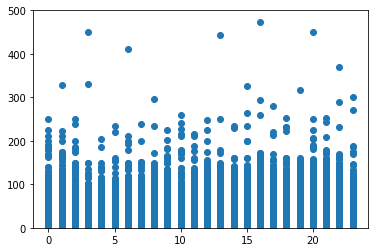

In [71]:
plt.scatter(ranged_data['hour_of_day'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

<BarContainer object of 24 artists>

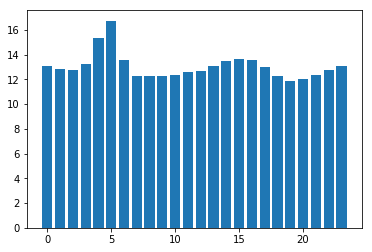

In [72]:
by_hour=ranged_data.groupby(by='hour_of_day')
#x = x.drop(x['day'] == 'Sunday')
x = by_hour.agg('mean')['fare_amount']
plt.bar(x.index,x)

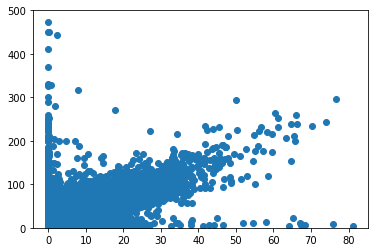

In [73]:
plt.scatter(ranged_data['distance'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

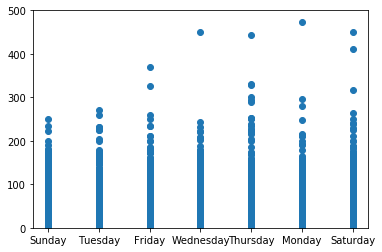

In [74]:
plt.scatter(ranged_data['day'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

<BarContainer object of 7 artists>

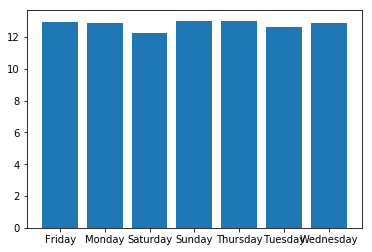

In [75]:
by_day=ranged_data.groupby(by='day')
#x = x.drop(x['day'] == 'Sunday')
x = by_day.agg('mean')['fare_amount']
plt.bar(x.index,x)

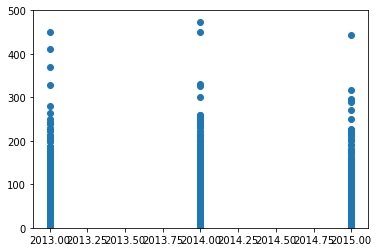

In [76]:
plt.scatter(ranged_data['year'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

<BarContainer object of 3 artists>

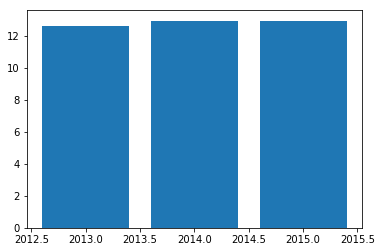

In [77]:
by_year=ranged_data.groupby(by='year')
x = by_year.agg('mean')['fare_amount']
plt.bar(x.index,x)

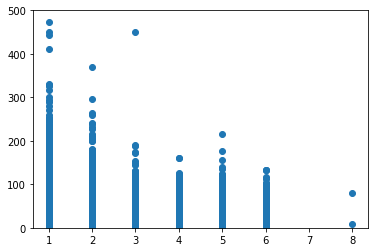

In [78]:
plt.scatter(ranged_data['passenger_count'],ranged_data['fare_amount'])
plt.ylim(0,500)
plt.show()

<BarContainer object of 7 artists>

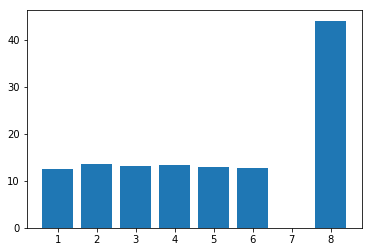

In [79]:
by_passCount=ranged_data.groupby(by='passenger_count')
x = by_passCount.agg('mean')['fare_amount']
plt.bar(x.index,x)

In [80]:
ranged_data.tail()

,Unnamed: 0.1,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,new_time,distance,year,hour_of_day,day,date,airport_ride
6379757,35320917,4.5,-73.993730,40.752420,-74.003162,40.754130,1,2013-04-20 07:06:00,0.816924,2013,7,Saturday,2013-04-20,False
3463404,32207177,10.0,-73.992430,40.737787,-74.008260,40.706132,1,2014-05-11 09:08:00,3.764198,2014,9,Sunday,2014-05-11,False
7685259,8813001,8.5,-73.953313,40.767437,-73.973020,40.782557,1,2014-06-27 17:43:32,2.362289,2014,17,Friday,2014-06-27,False
4036594,19969306,4.0,-74.004178,40.721869,-73.999299,40.722699,1,2014-12-08 07:34:58,0.421396,2014,7,Monday,2014-12-08,False
8993484,47388891,5.0,-73.992947,40.750114,-73.991988,40.749933,2,2014-12-31 06:47:48,0.083253,2014,6,Wednesday,2014-12-31,False


<BarContainer object of 2 artists>

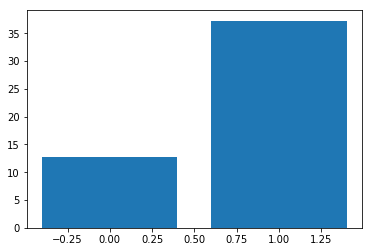

In [81]:
by_airport=ranged_data.groupby(by='airport_ride')
x = by_airport.agg('mean')['fare_amount']
plt.bar(x.index,x)

# Plots for number of rides

<BarContainer object of 24 artists>

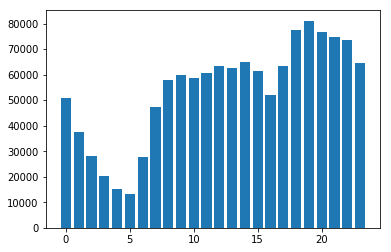

In [30]:
#Number of rides by hour of day
x = by_hour.size().reset_index(name='counts')
plt.bar(x['hour_of_day'],x['counts'])

<BarContainer object of 7 artists>

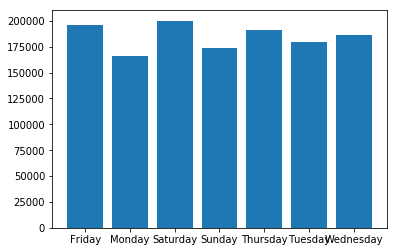

In [32]:
#Number of rides by day of week
x = by_day.size().reset_index(name='counts')
plt.bar(x['day'],x['counts'])

<BarContainer object of 3 artists>

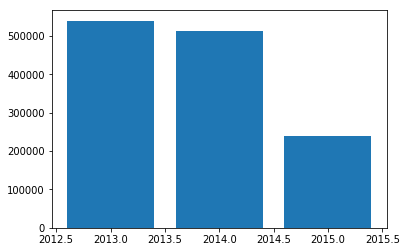

In [33]:
#Number of rides by day of week
x = by_year.size().reset_index(name='counts')
plt.bar(x['year'],x['counts'])

<BarContainer object of 2 artists>

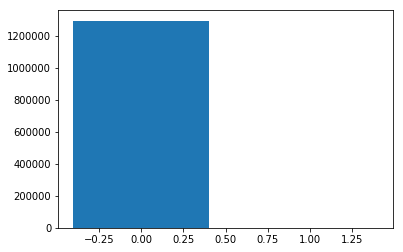

In [83]:
#Number of rides by whether airport ride
x = by_airport.size().reset_index(name='counts')
plt.bar(x['airport_ride'],x['counts'])